In [344]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment8.ipynb")

# DS 453 / 653: Programming Assignment 8

**Due date**: Thursday, April 11 at 8pm on [Gradescope](https://www.gradescope.com/courses/710247).

_You must follow the Academic Code of Conduct and Collaboration Policy stated in the course syllabus at all times while working on this assignment._

This assignment contains 2 questions. *Only the first part is auto-graded, and the second part will be manually graded*. You must successfully complete both parts in order to pass this assignment.

To begin, please execute the code block below:

In [345]:
import otter
grader = otter.Notebook()

## Assignment Overview

The goal of this assignment is to design a secure multi-party computation protocol.

### Problem setup

Here is the problem setup: David has four numbers $x_0$, $x_1$, and $x_2$, and he wants to compute the function $g(\vec{x}) = (x_0 \cdot x_1) + x_2$, where the entire computation occurs mod $256$.

If David had computing power, he would could the function on his own as shown in the following code block. (Note: the class `UInt8` will automatically perform modular arithmetic as needed to ensure that all integers stay in the range 0-255.)

In [346]:
# Execute this code block if using Google Colab, or else install this package yourself
# !pip install fixedint

In [347]:
# Execute this code block, and make sure you understand its output before continuing

from fixedint import UInt8

def g(x):
    return (x[0] * x[1]) + x[2]

David_inputs = [UInt8(14), UInt8(19), UInt8(10)]
print(type(David_inputs))

print(g(David_inputs))

<class 'list'>
20


Rather than computing the function on his own, however, David decides to outsource this computation. His friends Alice, Bob, and Carol are all willing to serve as cloud computing parties.

While David is grateful for their assistance, he does not fully trust his friends with this sensitive data. More specifically: David views his friends as _semi-honest_ -- he believes they are not faulty and will correctly execute any code that you write in this homework assignment, but it is important that they do not learn David's secret data in the process.

### Synchronous Network

To assist in this homework assignment, we're going to bring back the `SynchronousNetwork` from the previous homework. The following code block contains exactly the same code, except that the parties can send and receive lists of UInt8 numbers, rather than the values Zero, One, and Null in the previous homework.

In [348]:
## Execute, but DO NOT MODIFY this code block ##

from typing import List
import random
from fixedint import UInt8

# this method is used only for creating the debug log
def printList(x: List[UInt8]):
    if(x == None):
        return '[]'
    output = '[ '
    for i in x:
        output += str(i) + " "
    output += ']'
    return output

# The Party class is a base class representing a single participant in a distributed protocol.
# This party can choose what messages to send, and can record the contents of messages received.
class Party:
    def __init__(self, id: int, nb_faulty_parties: int, nb_total_parties: int, input: List[UInt8]):
        # Precondition: we guarantee that the party's id is between 1 and n
        self.id = id
        # In your code, you should assume that the party is honest
        # (we handle faulty parties separately in the SynchronousNetwork class)
        self.input = input
        self.is_faulty = False
        self.f = nb_faulty_parties
        self.n = nb_total_parties

    # send and receive proceeds in rounds
    # our SynchronousNetwork always completes one round before starting the next one
    def send(self, round_number: int, destination_party: int) -> List[UInt8]:
        return

    def receive(self, round_number: int, sender_party: int, val: List[UInt8]) -> None:
        # do an action based on what you receive from the sender party
        # but don't return anything
        return None

    # the output method is only run once at the end of the protocol
    # after all rounds of communication are complete
    def output(self):
        ## return what this party decides to output
        return

class SynchronousNetwork:
    # faulty parties only matter for the optional task
    def __init__(self, PartyType, nb_faulty_parties: int,
                 nb_total_parties: int, inputs: list, debug=False):
        # verify that f < n
        assert(nb_faulty_parties < nb_total_parties)
        assert(len(inputs) == nb_total_parties)
        self.debug = debug

        # creating several parties with the prescribed inputs
        self.parties = [PartyType(i, nb_faulty_parties, nb_total_parties,
                                  inputs[i-1]) for i in range(1, nb_total_parties + 1)]
        self.debug_print("Inputs:")
        for i in range(1, nb_total_parties + 1):
            self.debug_print("Party " + str(i) + " input: " + printList(inputs[i-1]))

        # randomly set some of the parties to be faulty, except the last one
        for p in random.sample(self.parties, nb_faulty_parties):
            if(p.id != 4):
                p.is_faulty = True
        self.leader = random.sample(self.parties, 1)[0]

    def run(self, nb_rounds) -> list:
        # execute all nb_rounds rounds of the synchronous protocol, in order
        for i in range(1, nb_rounds + 1):
            self.debug_print("\nStart of round " + str(i) + ":")

            for p1 in self.parties:
                for p2 in self.parties:
                    # each party can send one message to all parties (including itself!)
                    val = SynchronousNetwork.send_with_errors(i, p1, p2.id)
                    self.debug_print("party with id " + str(p1.id) + " sending to party with id " 
                                         + str(p2.id) + " a message with content: " + printList(val))

                    # recipient receives the message instantaneously
                    p2.receive(i, p1.id, val)

        # after all rounds are finished, retrieve each party's output
        res = [p.output() for p in self.parties]

        self.debug_print("\nDavid's output: " + str(res[3]) + "\n")
        return res

    def send_with_errors(round_nb, sender, recv) -> List[UInt8]:
        message = sender.send(round_nb, recv)

        # for honest parties or most of the time for faulty parties,
        # call the sender party and perform the action it wants
        r = random.random()
        if (not sender.is_faulty or r < 0.95):
            return message
        # for faulty parties, occasionally send random numbers
        # this case only matters for the optional task
        else:
            for i in range(len(message)):
                message[i] = UInt8(random.randrange(256))
            return message

    # pretty-printer that you can use to view the network communication
    def debug_print(self, obj):
        if self.debug:
            print(obj)
        else:
            pass

As a reminder: this code block provides two classes: a `Party` object that represents a single computer in a network, and a `SynchronousNetwork` that allows several `Party` objects to communicate. The network runs all of the parties (roughly) in parallel. You only have to write the code from the perspective of a single party $i$, and the network will handle the execution of all parties.

## Question 1: Construct the semi-honest 3-party secure computation protocol (3 points)

__Your task__: Write Python code that executes the secure 3-party computation protocol based on replicated secret sharing, in order to calculate the function $f(\vec{x})$.

Concretely, run a 4-party synchronous network where Alice, Bob, Carol, and David have party ids 1 through 4, respectively. Only David receives any inputs, and only David should receive an output. The other parties should only compute over secret self.shares of David's data.

__Your response__:

_Points:_ 3

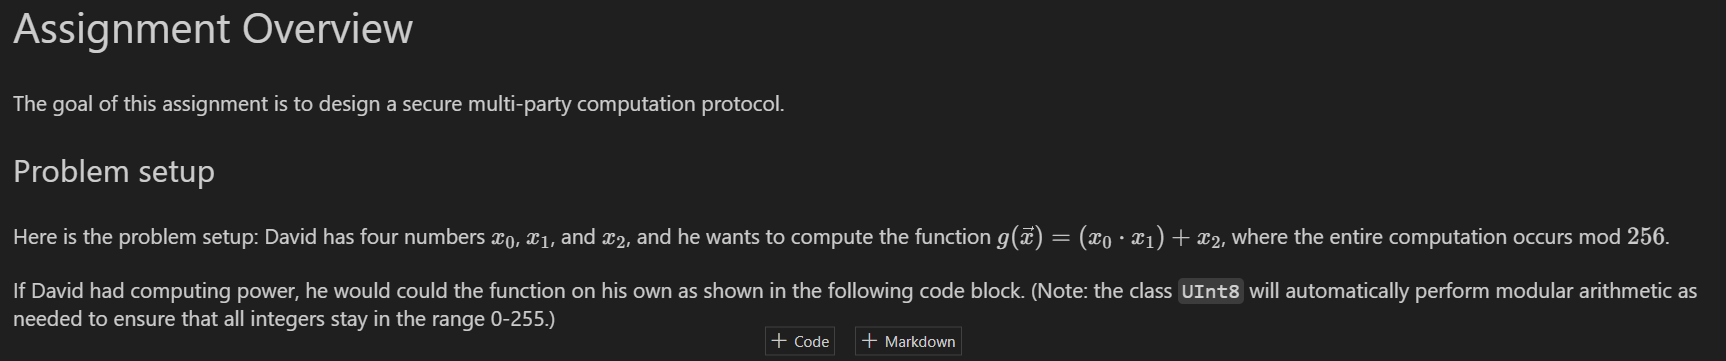

In [349]:
def split_two_shares(x):
        return x % 100, (x - x % 100) % 256

def split_three_shares(x):
        return x % 100, (x // 10) % 100, (x - (x % 100 + (x // 10) % 100)) % 256  

In [350]:
class MPCParty(Party):
    def __init__(self, *args, **kwargs):  # has the same arguments as the base class
        super().__init__(*args, **kwargs) # executes init from the base class
        # def __init__(self, id: int, nb_faulty_parties: int, nb_total_parties: int, input: List[UInt8]):
        
        # record the party's input
        if self.id == 4: # (works)
            self.n0 = self.input[0]
            self.n1 = self.input[1]
            self.n2 = self.input[2]

            self.shares0 = split_three_shares(self.n0)
            self.shares1 = split_three_shares(self.n1)
            self.shares2 = split_two_shares(self.n2)

            self.party_inputs = {
                1: [self.shares0[0], self.shares0[1], self.shares1[0], self.shares1[1]], # alice's values
                2: [self.shares0[1], self.shares0[2], self.shares1[1], self.shares1[2]], # bob's values
                3: [self.shares0[2], self.shares0[0], self.shares1[2], self.shares1[0]], # carol's values
            }
        
            self.output1 = []
            self.output2 = []

    def send(self, round_number: int, destination_party: int):

        # Sending (Alice, Bob, Carol) their values to multiply from (David)
        if round_number == 1 and self.id == 4 and destination_party in (1,2,3):
            return self.party_inputs[destination_party]
        
        # Sharing (Alice, Bob, Carol) their muliplied values to (David)
        if round_number == 2 and destination_party == 4 and self.id in (1,2,3):
            return [self.input[0] * self.input[2] + self.input[0] * self.input[3] + self.input[1] * self.input[2]]
        
        if round_number == 3 and self.id == 4:
            # split the multiplication result into two
            shares_m = split_two_shares(sum(self.output1))
            # sending alice and bob their values to add
            # self.m# is the split value of the multiplication
            # and self.n2# is the value to add
            if destination_party == 1:
                return [shares_m[0], self.shares2[0]]
            if destination_party == 2:
                return [shares_m[1], self.shares2[1]]
            
        # in the final round, 
        if round_number == 4 and self.id in (1,2) and destination_party == 4:
            return [self.input[0] + self.input[1]]      
        return None 
          

    def receive(self, round_number: int, sender_party: int, val: List[UInt8]):
        # TODO
        if sender_party == 4:
            # receiving values to mulitply (Alice, Bob, Carol) from (David)
            if round_number == 1 and self.id in (1,2,3):
                self.input = val
            # receiving values to add (Alice, Bob) from (David)
            if round_number == 3 and self.id in (1,2):
                self.input = val
        if self.id == 4:
            # adding multiplied values from other parties (Alice, Bob, Carol)
            if round_number == 2 and sender_party in (1,2,3):
                self.output1 += [val[0]]
            # adding values from other parties (Alice, Bob)
            if round_number == 4 and sender_party in (1,2):
                self.output2 += [val[0]]

    def output(self):
        # TODO
        return UInt8(sum(self.output2)) if self.id == 4 else None 

In [351]:
numRounds = 4 # replace this with the number of rounds in your protocol

# David has 3 inputs, and everyone else has none
mpc_inputs = [[],[],[], [UInt8(14), UInt8(19), UInt8(10)]]

# this question only asks about semi-honest security, so no parties are faulty
mpcNetwork = SynchronousNetwork(MPCParty, 0, 4, mpc_inputs, debug=True)
result = mpcNetwork.run(numRounds)
assert(result[3] == g(mpc_inputs[3]))

Inputs:
Party 1 input: [ ]
Party 2 input: [ ]
Party 3 input: [ ]
Party 4 input: [ 14 19 10 ]

Start of round 1:
party with id 1 sending to party with id 1 a message with content: []
party with id 1 sending to party with id 2 a message with content: []
party with id 1 sending to party with id 3 a message with content: []
party with id 1 sending to party with id 4 a message with content: []
party with id 2 sending to party with id 1 a message with content: []
party with id 2 sending to party with id 2 a message with content: []
party with id 2 sending to party with id 3 a message with content: []
party with id 2 sending to party with id 4 a message with content: []
party with id 3 sending to party with id 1 a message with content: []
party with id 3 sending to party with id 2 a message with content: []
party with id 3 sending to party with id 3 a message with content: []
party with id 3 sending to party with id 4 a message with content: []
party with id 4 sending to party with id 1 a mes

In [352]:
numRounds = 4
def test():
        global numRounds
        if not 'numRounds' in globals():
            numRounds = 2
        for _ in range(50000):
            mpc_inputs = [[], [], [], [UInt8(random.randrange(256)) for _ in range(3)]]
            mpcNetwork = SynchronousNetwork(MPCParty, 0, 4, mpc_inputs, debug=False)
            result = mpcNetwork.run(numRounds)
            assert result[3] == g(mpc_inputs[3])
        return True

test()

True

In [353]:
grader.check("q1")

q1 results:
    q1 - 1 result:
        ❌ Test case failed
        Trying:
            def test():
                numRounds = 2
                for _ in range(50000):
                    mpc_inputs = [[], [], [], [UInt8(random.randrange(256)) for _ in range(3)]]
                    mpcNetwork = SynchronousNetwork(MPCParty, 0, 4, mpc_inputs, debug=False)
                    result = mpcNetwork.run(numRounds)
                    assert result[3] == g(mpc_inputs[3])
                return True
        Expecting nothing
        ok
        Trying:
            test()
        Expecting:
            True
        **********************************************************************
        Line 9, in q1 0
        Failed example:
            test()
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\jackw\anaconda3\Lib\doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1 0[1]>", line 1, in <module>
                test()
              File "<doctest q1 0[0]>", line 7, in test
                assert result[3] == g(mpc_inputs[3])
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

## Question 2: Privacy of the secure computation protocol (2 points)

Recall that a secure multi-party computation protocol must satisfy _correctness_ and _privacy_. The auto-grader in Question 1 only checked for correctness, meaning that your code produces the same result as the `g` function.

__Your task:__ Explain in words why the protocol you implemented in Question 1 provides perfect privacy. That is: even though Alice, Bob, and Carol receive messages in this protocol, describe why they cannot learn anything about David's data. We anticipate that a response here should be around 1-2 paragraphs in length; that said, you may use any combination of words, code, formulas, figures, etc as needed to answer this question.

__Your response__:

The procotol I implementent in question 1 provides perfect privacy because the data is shared among the parties using secret sharing. The data is split into shares and distributed among the parties such that parties can only see their own shares and not the shares of the others. Each party only recieves a manipulated share of the true values from David, which by itself is meaningless and reveals no information about the original secret. The parties then perform computations on their shares and send the results back to David. Since the parties only have access to their own shares, they cannot learn anything about David's data. The shares are combined only at the end of the computation, when David receives the final result. This ensures that the parties cannot learn anything about David's data during the computation. 

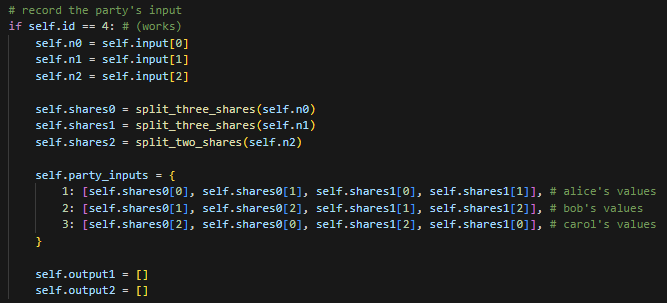

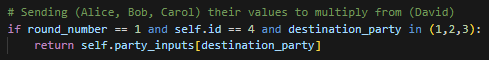

- Before the computation, David's data is split into shares and only two parts of each share are made available to each party.

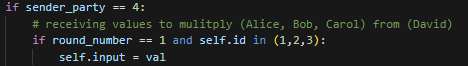

- The parties then receive their shares of the data as shown in the figure above.

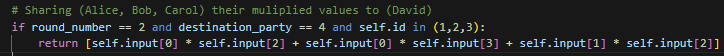

- During the computation, each party only has access to their own, fragmented share of the data. The computations are then sent directly back to David without revealing any information about the original data.

## Submitting the Assignment

Please follow these instructions to complete the assignment and submit it for credit.

**Documenting collaborators, sources, and AI tools:** In accordance with the collaboration policy, use the space below to report if you used any resources to complete this homework assignment, aside from the lecture notes and the course textbooks/videos. Specifically, please report:

1. Names of all classmates you worked with, and a short description of the work that you performed together.
2. All written materials that you used, such as books or websites (besides the lecture notes or textbooks). Please include links to any web-based resources, or citations to any physical works.
3. All code that you used from other sources. In particular, if you used an AI tool, then you must include the entire exchange with the AI tool, as per the [CDS Generative AI Assistance Policy](https://www.bu.edu/cds-faculty/culture-community/gaia-policy/).

Remember that if we discover any undocumented collaborators, sources, or AI tools then this is grounds for a grade penalty and referral to BU's Academic Conduct Committee (as described in the syllabus).

_Your response:_

1.

2.

3.

**Sending to Gradescope:** After completing the assignment:
- if you did the assignment on Colab, download it in `.ipynb` format.
- if you did the assignment locally on your machine, all you need to do is to find it in your directory.

Then, submit only the `.ipynb` file to this week's programming assignment on Gradescope. It may take a few seconds or a minute for the auto-grading system to check your work.

Remember that you can submit as many times as you want until the deadline for the assignment; only your last score counts.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit your assignment on Gradescope once you have passed enough tests to receive at least 4 of the 5 available points.

In [354]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

c:\Users\jackw\anaconda3\Lib\site-packages\otter\check\notebook.py:470: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")


OSError: xelatex not found on PATH, if you have not installed xelatex you may need to do so. Find further instructions at https://nbconvert.readthedocs.io/en/latest/install.html#installing-tex.